Các lớp: ['top-left', 'top-right', 'bottom-left', 'bottom-right']
Đã xóa các ảnh cũ trong thư mục đầu ra.


FileUpload(value=(), accept='image/*', description='Upload')

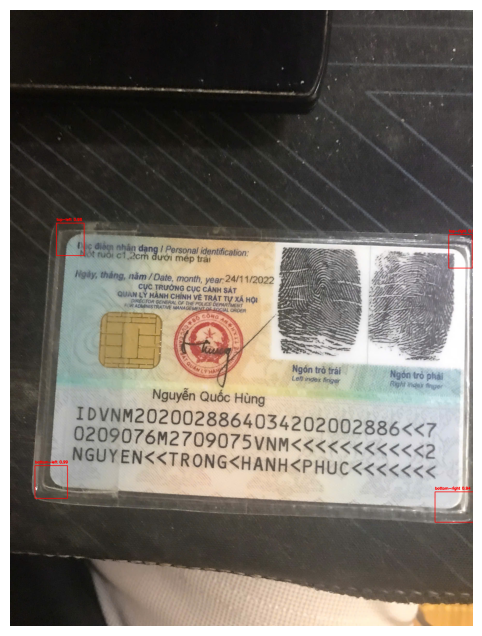

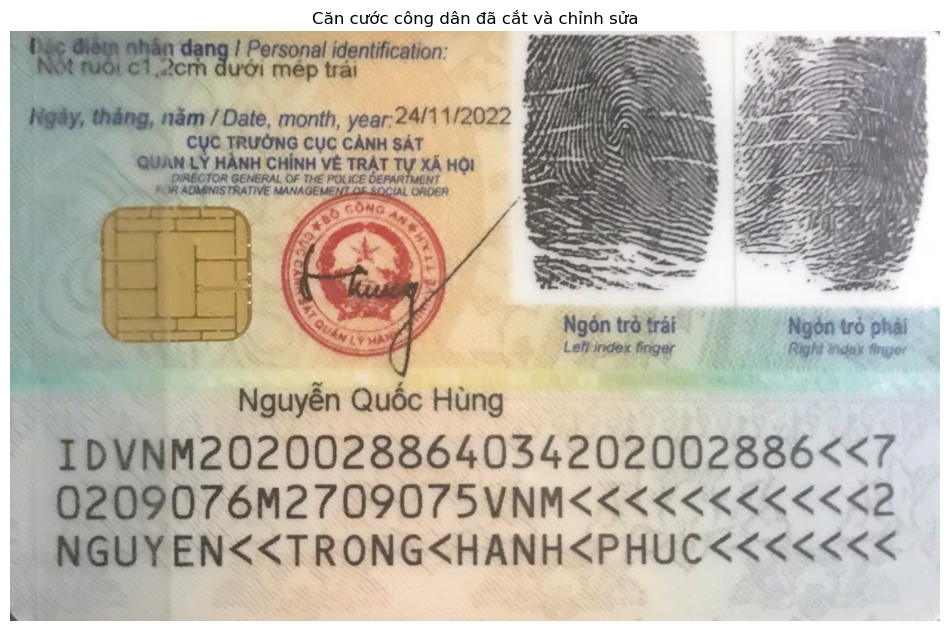

Đã lưu ảnh mới vào cơ sở dữ liệu: ../data/img/4gocsau/cropped_2.jpg
Đã hoàn thành quá trình xử lý.


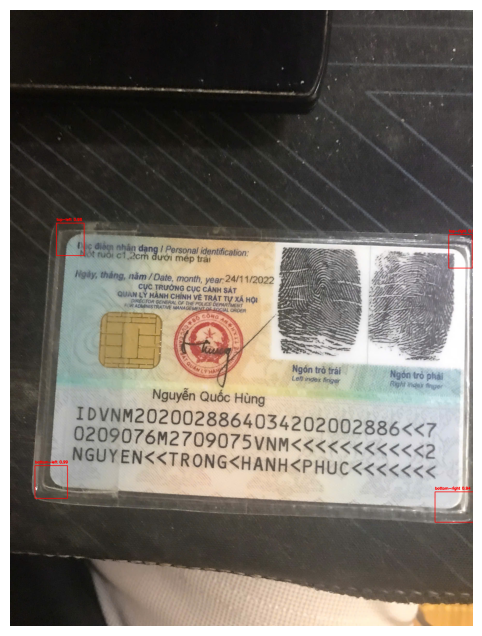

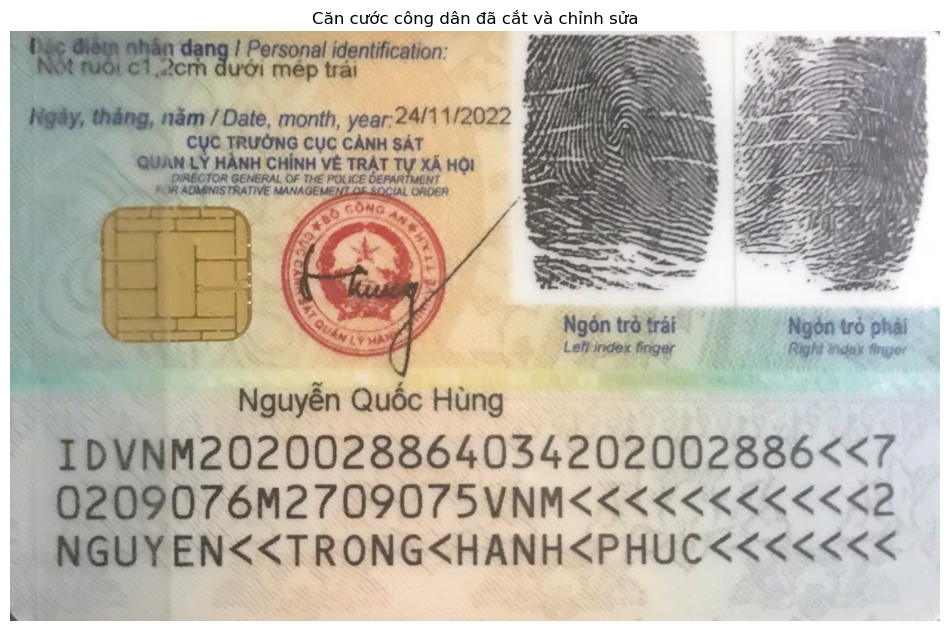

Đã cập nhật đường dẫn ảnh trong cơ sở dữ liệu: ../data/img/4gocsau/cropped_2.jpg
Đã hoàn thành quá trình xử lý.


In [1]:
import os
import cv2
import numpy as np
import sqlite3
from matplotlib import pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import tempfile

# Thiết lập đường dẫn
DB_PATH = '../data/database.db'
IMG_OUTPUT_DIR = '../data/img/4gocsau/'
MODEL_DIR = '../models'
CONFIG_PATH = os.path.join(MODEL_DIR, 'yolo-obj3.cfg')
WEIGHTS_PATH = os.path.join(MODEL_DIR, 'yolo-obj3_final.weights')
NAMES_PATH = os.path.join(MODEL_DIR, 'obj3.names')

# Tạo thư mục nếu chưa tồn tại
os.makedirs('../data', exist_ok=True)
os.makedirs(IMG_OUTPUT_DIR, exist_ok=True)

# Kết nối đến cơ sở dữ liệu
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

# Tạo bảng nếu chưa tồn tại
cursor.execute('''CREATE TABLE IF NOT EXISTS gocsau (input_name TEXT UNIQUE, output_path TEXT)''')
conn.commit()

# Hàm xóa ảnh cũ (nếu cần)
def clear_old_images():
    for file in os.listdir(IMG_OUTPUT_DIR):
        file_path = os.path.join(IMG_OUTPUT_DIR, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
    print("Đã xóa các ảnh cũ trong thư mục đầu ra.")

# Tải các lớp từ file obj.names
classes = []
with open(NAMES_PATH, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
print("Các lớp:", classes)

# Tải mô hình YOLO
net = cv2.dnn.readNet(WEIGHTS_PATH, CONFIG_PATH)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

CONF_THRESHOLD = 0.5
NMS_THRESHOLD = 0.4

# Hàm phát hiện đối tượng
def detect_objects(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape

    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)

    class_ids, confidences, boxes = [], [], []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > CONF_THRESHOLD:
                center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype('int')
                x, y = int(center_x - w / 2), int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, CONF_THRESHOLD, NMS_THRESHOLD)

    detections = []
    if len(indexes) > 0:
        for i in indexes.flatten():
            x, y, w, h = boxes[i]
            detections.append({
                'class_id': class_ids[i],
                'class_name': classes[class_ids[i]],
                'confidence': confidences[i],
                'box': [x, y, w, h]
            })

    return detections, img_rgb

# Hàm vẽ kết quả phát hiện
def draw_detections(img, detections):
    for det in detections:
        x, y, w, h = det['box']
        label = det['class_name']
        confidence = det['confidence']
        color = (255, 0, 0)  # Màu xanh dương cho bounding box

        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, f"{label} {confidence:.2f}", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Hàm lấy tọa độ các góc
def get_corner_points(detections):
    corners = {}
    for det in detections:
        class_name = det['class_name']
        box = det['box']
        x, y, w, h = box
        center_x = x + w / 2
        center_y = y + h / 2
        corners[class_name] = (center_x, center_y)
    return corners

# Hàm biến đổi phối cảnh
def four_point_transform(image, corners):
    required_keys = ['top-left', 'top-right', 'bottom-right', 'bottom-left']
    for key in required_keys:
        if key not in corners:
            raise ValueError(f"Thiếu góc: {key}")

    pts1 = np.float32([
        corners['top-left'],
        corners['top-right'],
        corners['bottom-right'],
        corners['bottom-left']
    ])

    widthA = np.linalg.norm(np.array(corners['bottom-right']) - np.array(corners['bottom-left']))
    widthB = np.linalg.norm(np.array(corners['top-right']) - np.array(corners['top-left']))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.linalg.norm(np.array(corners['top-right']) - np.array(corners['bottom-right']))
    heightB = np.linalg.norm(np.array(corners['top-left']) - np.array(corners['bottom-left']))
    maxHeight = max(int(heightA), int(heightB))

    pts2 = np.float32([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ])

    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    warped = cv2.warpPerspective(image, matrix, (maxWidth, maxHeight))

    return warped

# Hàm lưu và hiển thị ảnh (cập nhật để update thay vì insert mới)
def save_and_display(warped_image):
    input_image_name = uploaded_file_widget.value[0]['name']  
    
    output_image_path = os.path.join(IMG_OUTPUT_DIR,
                                      f"cropped_{os.path.basename(input_image_name)}")

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Căn cước công dân đã cắt và chỉnh sửa')
    plt.show()

    # Kiểm tra xem ảnh đã tồn tại trong cơ sở dữ liệu chưa trước khi lưu
    cursor.execute('SELECT COUNT(*) FROM gocsau WHERE input_name=?', (input_image_name.split('/')[-1],))
    
    if cursor.fetchone()[0] == 0:  
        # Nếu không có bản ghi nào thì mới chèn vào cơ sở dữ liệu
        # Lưu ảnh đã cắt
        cv2.imwrite(output_image_path, warped_image)

        # Lưu đường dẫn vào cơ sở dữ liệu
        cursor.execute('INSERT INTO gocsau (input_name, output_path) VALUES (?, ?)', 
                       (input_image_name.split('/')[-1], output_image_path))
        
        print(f"Đã lưu ảnh mới vào cơ sở dữ liệu: {output_image_path}")
    
    else:
        # Nếu đã tồn tại thì có thể cập nhật đường dẫn mới hoặc thông báo
        cursor.execute('UPDATE gocsau SET output_path=? WHERE input_name=?', 
                       (output_image_path , input_image_name.split('/')[-1]))
        
        # Lưu ảnh đã cắt nếu cần thiết (có thể bỏ qua nếu không muốn ghi đè)
        cv2.imwrite(output_image_path , warped_image)  
        
        print(f"Đã cập nhật đường dẫn ảnh trong cơ sở dữ liệu: {output_image_path}")

def clear_and_display(warped_image):
   save_and_display(warped_image)

# Xóa dữ liệu cũ trước khi bắt đầu (có thể điều chỉnh tham số clear_data nếu cần)
clear_old_images()

# Tạo widget để chọn tệp ảnh
uploaded_file_widget = widgets.FileUpload(
    accept='image/*',
    multiple=False,
)

display(uploaded_file_widget)

def process_image(change):
    if uploaded_file_widget.value:
        # Lấy thông tin tệp được tải lên từ danh sách đầu tiên
        uploaded_file_info = uploaded_file_widget.value[0]  
        
        # Lưu tệp vào một vị trí tạm thời để xử lý
        with tempfile.NamedTemporaryFile(delete=False) as temp_file:
            temp_file.write(uploaded_file_info['content'])
            temp_file_path = temp_file.name
        
        # Thực hiện phát hiện và cắt góc
        detections , img_rgb= detect_objects(temp_file_path)
        
        draw_detections(img_rgb.copy(), detections)
        
        corners= get_corner_points(detections)

        try:
            warped_image= four_point_transform(cv2.cvtColor(img_rgb.copy(), cv2.COLOR_RGB2BGR), corners)
            clear_and_display(warped_image) 
            conn.commit()  
            
            print("Đã hoàn thành quá trình xử lý.")
            
        except ValueError as e:
            print(e)

uploaded_file_widget.observe(process_image) 

# Đóng kết nối cơ sở dữ liệu khi hoàn tất (nên thực hiện sau khi chắc chắn không còn thao tác nào nữa).
def close_connection():
   conn.close()
